In [2]:
import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym 

from minatar_dqn.replay_buffer import ReplayBuffer
from experiments.experiment_utils import seed_everything
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from minatar_dqn.my_dqn import AgentDQN, build_environment
from experiments.experiment_utils import collect_training_output_files, collect_pruning_output_files

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [10]:
len(experiment_paths)

18

In [17]:
training_outputs_folder_path = (
    r"D:\Work\PhD\minatar_work\experiments\training\outputs"
)
training_timestamp_folder = "2023_07_10-21_30_43"

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

def get_records_from_training_experiment(experiment_files, stats_type = "validation"):
    
    checkpoint = torch.load(experiment_files["stats_path"])
    
    training_stats = checkpoint["training_stats"]
    validation_stats = checkpoint["validation_stats"]

    if stats_type == "training":
        flat_records = process_records_from_stats_and_config(training_stats, experiment_files["config_path"], stats_type)
    elif stats_type == "validation":
        flat_records = process_records_from_stats_and_config(validation_stats, experiment_files["config_path"], stats_type)
    
    return flat_records

def process_records_from_stats_and_config(stats, config_path, stats_type):

    flat_records = []
    for epoch_stats in stats:
        flat_stats = flatten(epoch_stats, reducer="underscore")  
        flat_stats["epoch_type"] = stats_type
        flat_records.append(flat_stats)

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # build experiment name cause I did not think to save some kind of 
    # exp name in config
    config_file_name = os.path.basename(config_path)
    exp_name_tokens = config_file_name.split("_")[:2]
    exp_name = "_".join(exp_name_tokens)

    # add info from the config file
    for record in flat_records:
        record["environment"] = config["environment"]
        record["seed"] = config["seed"]
        record["experiment_name"] = exp_name
        
    return flat_records

def collect_training_experiment_results(experiment_paths, stats="validation", train_epoch_counter = 200_000):
    records = []
    for experiment_files in experiment_paths:
        records.extend(get_records_from_training_experiment(experiment_files, stats_type=stats))

    df = pd.DataFrame.from_records(records)
    df["epoch"] = df["frame_stamp"] // train_epoch_counter 

    return df

# df = collect_training_experiment_results(experiment_paths, stats="validation")
df = collect_training_experiment_results(experiment_paths, stats="training")

df.head()

90


,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,episode_frames_median,...,policy_trained_times,target_trained_times,epoch_time,reward_contor_0,reward_contor_1,epoch_type,environment,seed,experiment_name,epoch
0,200000,0.0,30.0,0.677323,0.0,1.306540,11,790,85.172634,67.5,...,48749,1948,0 days 00:06:46.304972,198226,1589,training,asterix,0,conv32_lin128,1
1,400000,0.0,68.0,13.573561,7.0,14.565104,23,1020,425.658849,363.0,...,50000,2000,0 days 00:07:58.818326,193268,6366,training,asterix,0,conv32_lin128,2
2,600000,0.0,116.0,32.163880,34.0,20.510130,34,1389,667.849498,758.0,...,50000,2000,0 days 00:08:14.758195,190070,9617,training,asterix,0,conv32_lin128,3
3,800000,0.0,96.0,36.651246,40.0,21.421696,36,1204,711.875445,806.0,...,50000,2000,0 days 00:08:13.856276,189738,10299,training,asterix,0,conv32_lin128,4
4,1000000,0.0,96.0,41.141791,44.5,22.940271,25,1212,748.757463,863.0,...,50000,2000,0 days 00:08:07.682473,189641,11026,training,asterix,0,conv32_lin128,5


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


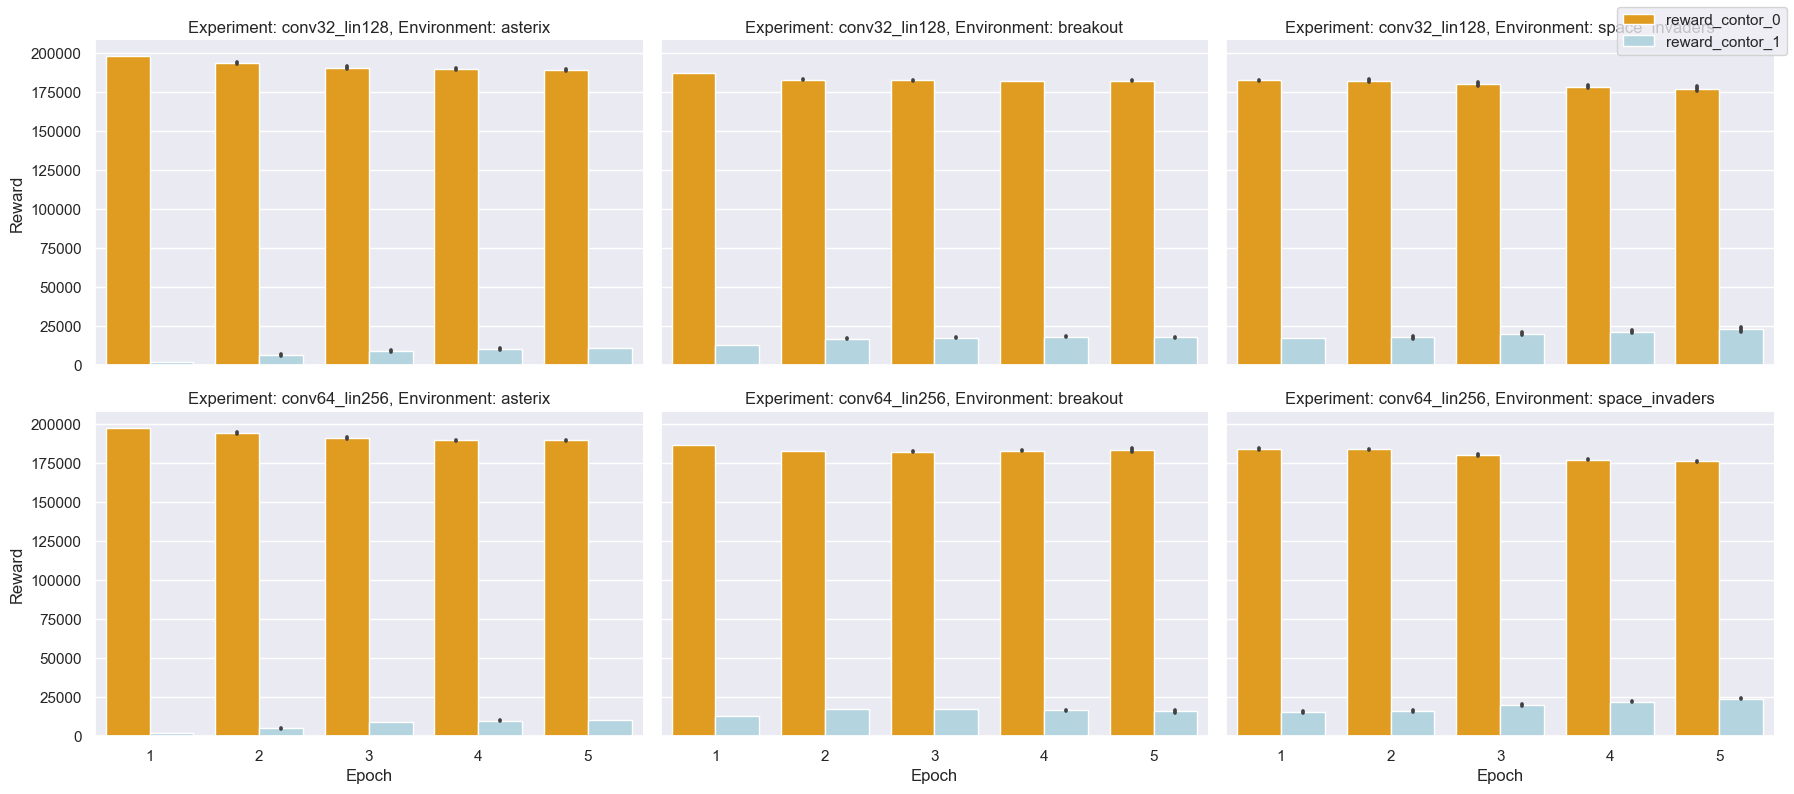

In [38]:
# Assuming your DataFrame is named `df`
df_pivot = df.melt(id_vars=['experiment_name', 'environment', 'epoch'],
                   value_vars=['reward_contor_0', 'reward_contor_1'],
                   var_name='reward_contor', value_name='counts')

g = sns.FacetGrid(df_pivot, row='experiment_name', col='environment', height=4, aspect=1.5)

g.map(sns.barplot, 'epoch', 'counts', 'reward_contor', palette=['orange', 'lightblue'])

g.set_titles('Experiment: {row_name}, Environment: {col_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()